In [ ]:
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [ ]:
import json
import string
import random 
import numpy as np
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import stanza
import spacy_stanza
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip.
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


Preprocessing

In [ ]:
import re
import unicodedata

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

Diccionario de entrada

In [ ]:
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "reserva",
              "patterns": ["¿qué habitaciones tienen disponibles?", "quiero hacer una reserva", "tienen disponible una suite?"],
              "responses": ["Por favor indique cantidad de huéspedes y fechas"]
             },
            {"tag": "cambios de reserva",
              "patterns": ["tengo una reserva", "me gustaría cambiar una reserva", "quiero cancelar una reserva"],
              "responses": ["Por modificaciones en su reserva, contactenos a nuestro whatsapp"]
             },
            {"tag": "transporte",
              "patterns": ["transporte aeropuerto", "taxi hasta el hotel"],
              "responses": ["Ofrecemos servicio de transporte desde/hacia el aeropuerto. Para más información ingrese en la sección Transporte"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "cuánto cuesta por noche", "¿Cuánto sale?"],
              "responses": ["En la sección Tarifas encontrará toda la información sobre precio final por noche."]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["Aceptamos efectivo en moneda local, tarjetas de débito Visa y Maestro, crédito Visa, American Express y Mastercard en una sola cuota. No aceptamos mercadopago ni tranferencias bancarias."]
             },
            {"tag": "spa",
              "patterns": ["Se puede usar el sauna?", "¿la pileta está habilitada?", "¿cuál es el horario de masajes?"],
              "responses": ["Para información sobre el uso de las instalaciones del spa, visite la sección Spa."]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["De nada!, esperamos que disfrutes tu estadía"]
             },
             {"tag": "lavandería",
              "patterns": [ "tienen lavandería?", "servicio de lavado de ropa"],
              "responses": ["Por el momento el hotel no cuenta con servicio de lavandería."]
             }
]}

In [ ]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['aeropuerto', 'cambiar', 'cancelar', 'como', 'costar', 'credito', 'cual', 'cuanto', 'cuota', 'de', 'disponible', 'el', 'este', 'gracias', 'gustar', 'habilitado', 'habitación', 'hacer', 'hasta', 'holar', 'horario', 'hotel', 'lavado', 'lavanderia', 'masaje', 'medio', 'mucho', 'noche', 'pago', 'pasar', 'pileta', 'poder', 'por', 'precio', 'que', 'querer', 'reserva', 'ropa', 'salir', 'sauna', 'ser', 'servicio', 'suite', 'tal', 'tarjeta', 'taxi', 'tener', 'transporte', 'uno', 'usar', 'yo', 'él']
classes: ['agradecimientos', 'bienvenida', 'cambios de reserva', 'lavandería', 'pagos', 'precios', 'reserva', 'spa', 'transporte']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿qué habitaciones tienen disponibles?', 'quiero hacer una reserva', 'tienen disponible una suite?', 'tengo una reserva', 'me gustaría cambiar una reserva', 'quiero cancelar una reserva', 'transporte aeropuerto', 'taxi hasta el hotel', 'precio', 'Me podrás pasar los precios', 'cuánto cuesta por noche', '¿Cuánto sale?', 

In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Training

In [ ]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (52,) output: 9


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               6784      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 9)                 585       
                                                                 
Total params: 15,625
Trainable params: 15,625
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
hist = model.fit(x=train_X, y=train_y, epochs=200)


Epoch 1/200
1/1 [==============================] - 0s 497ms/step - loss: 2.2692 - accuracy: 0.1538
Epoch 2/200
1/1 [==============================] - 0s 13ms/step - loss: 2.1715 - accuracy: 0.2692
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 2.2035 - accuracy: 0.0769
Epoch 4/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2412 - accuracy: 0.1923
Epoch 5/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1407 - accuracy: 0.0769
Epoch 6/200
1/1 [==============================] - 0s 15ms/step - loss: 2.1964 - accuracy: 0.1154
Epoch 7/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1735 - accuracy: 0.2308
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1632 - accuracy: 0.0769
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 2.1626 - accuracy: 0.1538
Epoch 10/200
1/1 [==============================] - 0s 10ms/step - loss: 2.0413 - accuracy: 0.2308
Epoch 11/200
1/1 [===

Grafico accuracy

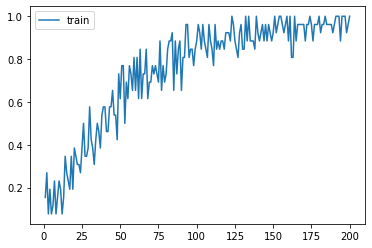

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [ ]:
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

Testing y validación

In [ ]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")

1/1 [==============================] - 0s 53ms/step
BOT: Ofrecemos servicio de transporte desde/hacia el aeropuerto. Para más información ingrese en la sección Transporte
1/1 [==============================] - 0s 17ms/step
BOT: En la sección Tarifas encontrará toda la información sobre precio final por noche.
